In [96]:
import re

import wandb
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Rectangle
from scipy.stats import bootstrap
from collections import defaultdict
from scipy.ndimage import histogram
from matplotlib.patches import FancyArrowPatch
import matplotlib.ticker as mticker


plt.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": "lualatex",
    "pgf.rcfonts": False,
    "text.latex.preamble": r"\usepackage{amsmath}",
    "pgf.preamble": "\n".join([
        r"\usepackage{fontspec}",
        r"\setmainfont{TeX Gyre Termes}",
        r"\setsansfont{TeX Gyre Heros}",
        r"\setmonofont{TeX Gyre Cursor}",
        r"\usepackage{amsmath}"
    ]),
})



class HandlerTitle(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):
        # This method should return a list of artists (lines, patches)
        # to draw for the legend handle. We return an empty list
        # to draw nothing and reserve no space.
        return []
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        # This is the new, crucial part.
        # The legend_artist method MUST return a single artist.
        # We create a completely transparent and zero-width Rectangle.
        # This satisfies the requirement of returning an artist, but
        # it will be invisible and take up no space.
        handlebox.set_width(0)
        handlebox.set_height(0)
        patch = Rectangle(xy=(-0.5*handlebox.width, -0.5*handlebox.height),
                          width=0, height=0, facecolor='none', edgecolor='none')
        handlebox.add_artist(patch)
        return patch

def nested_dict():
    return defaultdict(nested_dict)


def ci_95(data):
    if len(data) < 2:
        return (-1, -1)
    res = bootstrap((np.array(data),), np.mean, confidence_level=0.95, n_resamples=1000, method="basic")
    return res.confidence_interval.low.astype(np.int64), res.confidence_interval.high.astype(np.int64)


def bootstrap_mean_ci(trajectories, n_bootstraps=1000, ci=95):
    """
    Calculates the mean and confidence interval for a set of trajectories.

    Args:
        trajectories (np.ndarray): A 2D numpy array where each row is a trajectory.
                                   Shape: (n_trajectories, n_timepoints).
        n_bootstraps (int): The number of bootstrap samples to generate.
        ci (int): The desired confidence interval in percent.

    Returns:
        tuple: A tuple containing:
            - mean_trajectory (np.ndarray): The mean trajectory.
            - ci_lower (np.ndarray): The lower bound of the confidence interval.
            - ci_upper (np.ndarray): The upper bound of the confidence interval.
    """
    n_trajectories, n_timepoints = trajectories.shape
    bootstrap_means = np.zeros((n_bootstraps, n_timepoints))

    for i in range(n_bootstraps):
        indices = np.random.choice(n_trajectories, size=n_trajectories, replace=True)
        bootstrap_sample = trajectories[indices, :]
        bootstrap_means[i, :] = np.mean(bootstrap_sample, axis=0)

    mean_trajectory = np.mean(trajectories, axis=0)

    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile

    ci_lower, ci_upper = np.percentile(
        bootstrap_means, [lower_percentile, upper_percentile], axis=0
    )

    return mean_trajectory, ci_lower, ci_upper

def to_plain_dict(obj):
    if isinstance(obj, defaultdict):
        return {k: to_plain_dict(v) for k, v in obj.items()}
    if isinstance(obj, dict):
        return {k: to_plain_dict(v) for k, v in obj.items()}
    return obj

In [97]:
group_map = {}
env_translation = {
    "Pendulum": "BalancePendulum",
    "Quadrotor": "BalanceQuadrotor",
    "Energy System": "LoadBalanceHousehold"
}
safeguard_translation = {
    "No Safeguard": "NP",
    "Boundary Projection Base": "P",
    "Boundary Projection Regularised": "P",
    "Ray Mask Base": "ZRP-Lin",
    "Ray Mask Regularised": "ZRP-Lin",
    "Ray Mask Passthrough": "ZRP-Lin-PT",
    "Hyperbolic Ray Mask Base": "ZRP-Tanh",
    "Hyperbolic Ray Mask Regularised": "ZRP-Tanh",
    "Ray Mask Orthogonal": "ORP-Lin"
}
safeguard_table = {
    "Boundary Projection Base": ("BP", "Base"),
    "Boundary Projection Regularised": ("BP", "Regularised"),
    "Ray Mask Base": ("RM", "Base"),
    "Ray Mask Regularised": ("RM", "Regularised"),
    "Ray Mask Passthrough": ("RM", "Passthrough"),
    "Hyperbolic Ray Mask Base": ("HRM", "Base"),
    "Hyperbolic Ray Mask Regularised": ("HRM", "Regularised"),
}

algorithms = ["SHAC", "SAC", "PPO"]
for env in env_translation.keys():
    for algo in algorithms:
        for safeguard in safeguard_translation.keys():
            translation = safeguard_translation[safeguard]
            if env == "Energy System" and translation == "P":
                translation = translation.replace("P", "BP")
            elif env == "Energy System" and "ZRP" in translation:
                translation = translation.replace("ZRP", "ZRM")
            elif env == "Energy System" and "ORP" in translation:
                translation = translation.replace("ORP", "ORM")

            key = env_translation[env] + "-" + translation + "-" + algo
            key += "" if "Regularised" not in safeguard else "-Reg"

            group_map[key] = (env, algo, safeguard)

stuck_runs = {
    "Pendulum": {
        "SHAC": {
            "No Safeguard": ["likely-paper-5140"],
            "Boundary Projection Base": ["clean-universe-5155", "trim-shadow-5153"],
            "Boundary Projection Regularised": ["turtle-brulee-5032"],
            "Ray Mask Base": [],
            "Ray Mask Regularised": [],
            "Ray Mask Passthrough": ["happy-shadow-5213", "boysenberry-strudel-5040"],
            "Hyperbolic Ray Mask Base": ["different-terrain-5205"],
            "Hyperbolic Ray Mask Regularised": [],
            "Ray Mask Orthogonal": []
        },
        "PPO": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        },
        "SAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        }},
    "Quadrotor": {
        "SHAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Boundary Projection Regularised": [],
            "Ray Mask Base": [],
            "Ray Mask Regularised": [],
            "Ray Mask Passthrough": ["comfy-gorge-5215"],
            "Hyperbolic Ray Mask Base": [],
            "Hyperbolic Ray Mask Regularised": [],
            "Ray Mask Orthogonal": []
        },
        "PPO": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        },
        "SAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        }},
    "Energy System": {
        "SHAC": {
            "No Safeguard": ["firm-dragon-5811"],
            "Boundary Projection Base": [],
            "Boundary Projection Regularised": [],
            "Ray Mask Base": [],
            "Ray Mask Regularised": [],
            "Ray Mask Passthrough": ["rose-planet-5945", "cosmic-waterfall-5950"],
            "Hyperbolic Ray Mask Base": [],
            "Hyperbolic Ray Mask Regularised": [],
            "Ray Mask Orthogonal": []
        },
        "PPO": {
            "No Safeguard": ["dark-haze-6093", "legendary-energy-6087"],
            "Boundary Projection Base": ["dark-totem-6095", "atomic-elevator-6101", "glamorous-bee-6100"],
            "Ray Mask Base": [],
        },
        "SAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        }},
}

In [98]:
if Path("results.pt").exists():
    results = torch.load(Path("results.pt"), weights_only=False)
    timing_results = torch.load(Path("timing_results.pt"), weights_only=False)
else:
    api = wandb.Api()

    entity = "tim-walter-tum"
    project = "Safe Differentiable Reinforcement Learning"

    runs = api.runs(f"{entity}/{project}")

    results = nested_dict()
    timing_results = nested_dict()

    for run in api.runs(f"{entity}/{project}"):
        try:
            group = run.group
            if group not in group_map:
                continue
            env, algo, safeguard = group_map[group]
            if run.name in stuck_runs[env][algo][safeguard]:
                continue
            if "Timing" in run.name:
                timing_results[env][algo][safeguard] = run.summary['_wandb']['runtime']
            else:
                rewards = run.history(keys=["eval/Episodic Reward"])["eval/Episodic Reward"].dropna().values
                steps = run.history(keys=["eval/Episodic Reward"])["_step"].dropna().values

                threshold = rewards[-1] * 0.95 if rewards[-1] > 0 else rewards[-1] * 1.05
                idx = np.where(rewards >= threshold)[0]
                nr_steps = steps[idx[0]] if len(idx) > 0 else steps[-1]

                if len(results[env][algo][safeguard]) == 0:
                    results[env][algo][safeguard] = {"nr_steps": [], "reward": np.array([rewards])}
                else:
                    if results[env][algo][safeguard]["reward"].shape[1] != len(rewards):
                        results[env][algo][safeguard]["reward"] = np.vstack(
                            [results[env][algo][safeguard]["reward"], rewards[:-1]])
                    else:
                        results[env][algo][safeguard]["reward"] = np.vstack(
                            [results[env][algo][safeguard]["reward"], rewards])

                results[env][algo][safeguard]["nr_steps"] += [nr_steps]
                results[env][algo][safeguard]["steps"] = steps
        except Exception as e:
            print(e)
            print(run.group)
            print(run.name)
    results_plain = to_plain_dict(results)
    timing_plain = to_plain_dict(timing_results)

    torch.save(results_plain, "results.pt")
    torch.save(timing_plain, "timing_results.pt")

In [99]:
#Table 2
print(r"""
\begin{table*}
  \centering
  \caption{Comparison of learning learning_algorithms in unsafe training.}
  \label{tab:unsafe}
  \begin{tabular}{l l r r r r r}
    \toprule
    \multirow{2}{*}{Environment} & \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Return} & \multirow{2}{*}{\# Stuck} \\
    & & Mean & 95\% CI & Mean & 95\% CI & \\""")

for env in results.keys():
    print(rf"""
    \midrule
    \multirow{{3}}{{*}}{{{env}}}
    """)
    for algo in algorithms:
        res = results[env][algo]["No Safeguard"]

        mean_steps = int(np.mean(res["nr_steps"]))
        low_steps, high_steps = ci_95(res["nr_steps"])

        mean_reward = int(np.mean(res["reward"][:, -1]))
        low_reward, high_reward = ci_95(res["reward"][:, -1])

        nr_stuck = len(stuck_runs[env][algo]["No Safeguard"])
        print(
            rf"""&{algo} & {mean_steps} & [{low_steps}, {high_steps}] & {mean_reward} & [{low_reward}, {high_reward}] & {nr_stuck} / 10  \\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table*}""")


\begin{table*}
  \centering
  \caption{Comparison of learning learning_algorithms in unsafe training.}
  \label{tab:unsafe}
  \begin{tabular}{l l r r r r r}
    \toprule
    \multirow{2}{*}{Environment} & \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Return} & \multirow{2}{*}{\# Stuck} \\
    & & Mean & 95\% CI & Mean & 95\% CI & \\

    \midrule
    \multirow{3}{*}{Pendulum}
    
&SHAC & 12800 & [10808, 15075] & -8 & [-8, -8] & 1 / 10  \\
&SAC & 8513 & [6260, 10767] & -14 & [-15, -12] & 0 / 10  \\
&PPO & 81600 & [81600, 81600] & -596 & [-1174, 300] & 0 / 10  \\

    \midrule
    \multirow{3}{*}{Quadrotor}
    
&SHAC & 20364 & [11008, 26983] & -157 & [-169, -141] & 0 / 10  \\
&SAC & 80628 & [59094, 108673] & -1046 & [-1856, 167] & 0 / 10  \\
&PPO & 80640 & [44800, 118720] & -1710 & [-2141, -1274] & 0 / 10  \\

    \midrule
    \multirow{3}{*}{Energy System}
    
&SHAC & 259600 & [83563, 397466] & -114164 & [-146726, -77523] & 1 / 10  \\
&SAC & 674999 & 

In [100]:
# Table 3
print(r"""
\begin{table*}
  \centering
  \caption{Comparison of learning learning_algorithms in safeguarded training.}
  \label{tab:safe}
  \begin{tabular}{l l r r r r r r}
    \toprule
    \multirow{2}{*}{Environment} &\multirow{2}{*}{Safeguard} & \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Return} & \multirow{2}{*}{\# Stuck} \\
    & & & Mean & 95\% CI & Mean & 95\% CI & \\""")

for env in results.keys():
    print(rf"""
    \midrule
    \midrule
    \multirow{{6}}{{*}}{{{env}}}
    """)
    for short_safeguard in ["BP", "RM"]:
        if short_safeguard == "BP":
            safeguard = "Boundary Projection Base"
        else:
            safeguard = "Ray Mask Base"
            print(rf"""\cmidrule{{2-8}}""")
        for algo in algorithms:
            res = results[env][algo][safeguard]
            try:
                mean_steps = int(np.mean(res["nr_steps"]))
                low_steps, high_steps = ci_95(res["nr_steps"])

                mean_reward = int(np.mean(res["reward"][:, -1]))
                low_reward, high_reward = ci_95(res["reward"][:, -1])

                nr_stuck = len(stuck_runs[env][algo][safeguard])
            except TypeError:
                pass
            print(
                rf"""& {rf'\multirow{{3}}{{*}}{{{short_safeguard}}}' if algo == "SHAC" else ""} & {algo} & {mean_steps} & [{low_steps}, {high_steps}] & {mean_reward} & [{low_reward}, {high_reward}] & {nr_stuck} / 10\\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table*}""")


\begin{table*}
  \centering
  \caption{Comparison of learning learning_algorithms in safeguarded training.}
  \label{tab:safe}
  \begin{tabular}{l l r r r r r r}
    \toprule
    \multirow{2}{*}{Environment} &\multirow{2}{*}{Safeguard} & \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Return} & \multirow{2}{*}{\# Stuck} \\
    & & & Mean & 95\% CI & Mean & 95\% CI & \\

    \midrule
    \midrule
    \multirow{6}{*}{Pendulum}
    
& \multirow{3}{*}{BP} & SHAC & 23360 & [18552, 28167] & -8 & [-8, -8] & 2 / 10\\
&  & SAC & 2504 & [2504, 2504] & -1083 & [-1105, -1062] & 0 / 10\\
&  & PPO & 80240 & [78880, 82960] & -10 & [-10, -9] & 0 / 10\\
\cmidrule{2-8}
& \multirow{3}{*}{RM} & SHAC & 27392 & [20992, 33280] & -8 & [-8, -8] & 0 / 10\\
&  & SAC & 2504 & [2504, 2504] & -424 & [-463, -386] & 0 / 10\\
&  & PPO & 76160 & [72080, 80240] & -12 & [-12, -11] & 0 / 10\\

    \midrule
    \midrule
    \multirow{6}{*}{Quadrotor}
    
& \multirow{3}{*}{BP} & SHAC & 45683 

In [101]:
# Table 4
print(r"""
\begin{table}
  \centering
  \caption{Number of non-convergent runs for the various safeguards.}
  \label{tab:excluded}
  \begin{tabular}{l l r r r}
    \toprule
    \multicolumn{2}{l}{\multirow{2}{*}{Safeguard}} & \multicolumn{3}{c}{\# Stuck} \\
     & & Pen & Quad & ES \\""")
for safeguard in safeguard_translation.keys():
    if safeguard == "No Safeguard" or safeguard == "Ray Mask Orthogonal":
        continue
    base, mod = safeguard_table[safeguard]
    nr_stuck_pen = len(stuck_runs["Pendulum"]["SHAC"][safeguard])
    nr_stuck_quad = len(stuck_runs["Quadrotor"]["SHAC"][safeguard])
    nr_stuck_es = len(stuck_runs["Energy System"]["SHAC"][safeguard])
    print(rf"""{r'\midrule' if mod == "Base" else ''}
    {rf'\multirow{{{2 if base == "BP" or base == "HRM" else 3}}}{{*}}{{{base}}}' if mod == "Base" else ''} & {mod} & {nr_stuck_pen} / 10 & {nr_stuck_quad} / 10 & {nr_stuck_es} / 10 \\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table}""")


\begin{table}
  \centering
  \caption{Number of non-convergent runs for the various safeguards.}
  \label{tab:excluded}
  \begin{tabular}{l l r r r}
    \toprule
    \multicolumn{2}{l}{\multirow{2}{*}{Safeguard}} & \multicolumn{3}{c}{\# Stuck} \\
     & & Pen & Quad & ES \\
\midrule
    \multirow{2}{*}{BP} & Base & 2 / 10 & 0 / 10 & 0 / 10 \\

     & Regularised & 1 / 10 & 0 / 10 & 0 / 10 \\
\midrule
    \multirow{3}{*}{RM} & Base & 0 / 10 & 0 / 10 & 0 / 10 \\

     & Regularised & 0 / 10 & 0 / 10 & 0 / 10 \\

     & Passthrough & 2 / 10 & 1 / 10 & 2 / 10 \\
\midrule
    \multirow{2}{*}{HRM} & Base & 1 / 10 & 0 / 10 & 0 / 10 \\

     & Regularised & 0 / 10 & 0 / 10 & 0 / 10 \\
    \bottomrule
  \end{tabular}
\end{table}


In [102]:
# Table 5
print(r"""
\begin{table*}
  \centering
  \caption{Comparison of the safe centre approximations.}
  \label{tab:orp}
  \begin{tabular}{l l r r r r r}
    \toprule
    \multirow{2}{*}{Environment} & \multirow{2}{*}{Approximation} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Return} & \multirow{2}{*}{\# Stuck} \\
    && Mean & 95\% CI & Mean & 95\% CI & \\""")

for env in results.keys():
    print(rf"""
    \midrule
    \multirow{{2}}{{*}}{{{env}}}
    """)
    for safeguard in ["Ray Mask Base", "Ray Mask Orthogonal"]:
        approximation = "Zonotopic" if safeguard == "Ray Mask Base" else "Orthogonal"

        res = results[env]["SHAC"][safeguard]
        try:
            mean_steps = int(np.mean(res["nr_steps"]))
            low_steps, high_steps = ci_95(res["nr_steps"])

            mean_reward = int(np.mean(res["reward"][:, -1]))
            low_reward, high_reward = ci_95(res["reward"][:, -1])

            nr_stuck = len(stuck_runs[env]["SHAC"][safeguard])
        except TypeError:
            pass
        print(
            rf"""&{approximation} & {mean_steps} & [{low_steps}, {high_steps}] & {mean_reward} & [{low_reward}, {high_reward}] & {nr_stuck} / 10 \\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table*}""")



\begin{table*}
  \centering
  \caption{Comparison of the safe centre approximations.}
  \label{tab:orp}
  \begin{tabular}{l l r r r r r}
    \toprule
    \multirow{2}{*}{Environment} & \multirow{2}{*}{Approximation} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Return} & \multirow{2}{*}{\# Stuck} \\
    && Mean & 95\% CI & Mean & 95\% CI & \\

    \midrule
    \multirow{2}{*}{Pendulum}
    
&Zonotopic & 27392 & [20480, 33280] & -8 & [-8, -8] & 0 / 10 \\
&Orthogonal & 30208 & [18432, 38912] & -8 & [-8, -8] & 0 / 10 \\

    \midrule
    \multirow{2}{*}{Quadrotor}
    
&Zonotopic & 67148 & [31909, 97448] & -251 & [-307, -193] & 0 / 10 \\
&Orthogonal & 31372 & [6577, 57241] & -432 & [-478, -373] & 0 / 10 \\

    \midrule
    \multirow{2}{*}{Energy System}
    
&Zonotopic & 709280 & [577247, 836462] & -8793 & [-12609, -3195] & 0 / 10 \\
&Orthogonal & 109560 & [77880, 141240] & -79594 & [-89156, -70463] & 0 / 10 \\
    \bottomrule
  \end{tabular}
\end{table*}


In [103]:
# Table 6 manual

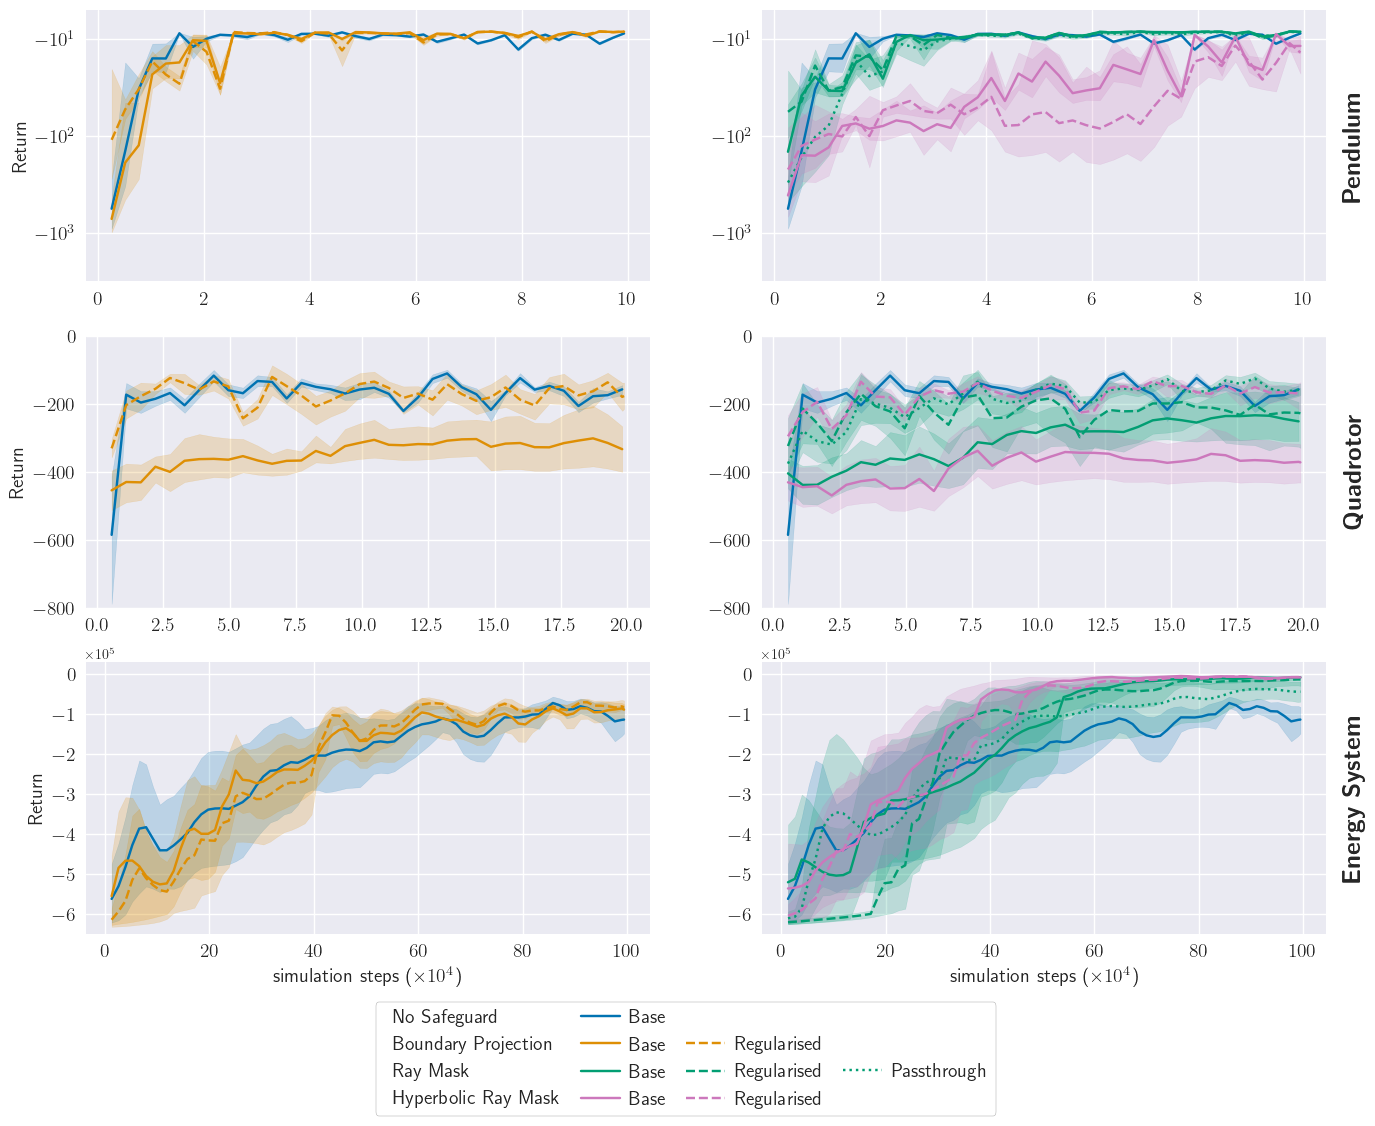

In [104]:
# Figure 5
plt.style.use("seaborn-v0_8")

colors = {
    "No Safeguard": sns.color_palette("colorblind")[0],
    "Boundary Projection": sns.color_palette("colorblind")[1],
    "Ray Mask": sns.color_palette("colorblind")[2],
    "Hyperbolic Ray Mask": sns.color_palette("colorblind")[4],
}

styles = {
    "Base": "solid",
    "Regularised": "dashed",
    "Passthrough": "dotted",
}

row = {
    "Pendulum": 0,
    "Quadrotor": 1,
    "Energy System": 2,
}

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=False, sharey=False)

for ax, title in zip(axes[:, 1], ["Pendulum", "Quadrotor", "Energy System"]):
    ax.text(1.05, 0.5, rf"\textbf{{{title}}}", va='center', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=18)
for ax in axes[:, 0]:
    ax.set_ylabel("Return", fontsize=14)
for ax in axes[-1, :]:
    ax.set_xlabel(r"simulation steps ($\times 10^4$)", fontsize=14)
for ax in axes[0, :]:
    ax.set_yscale("symlog")
for ax in axes[1, :]:
    ax.set_ylim([-800, -100])
    ax.set_yticks([-600, -400, -200])

for env in env_translation.keys():
    for safeguard in safeguard_translation.keys():
        if safeguard == "Ray Mask Orthogonal":
            continue
        x = results[env]["SHAC"][safeguard]["steps"] / 1e4
        y, y_lower, y_upper = bootstrap_mean_ci(results[env]["SHAC"][safeguard]["reward"])
        if len(x) != len(y):
            x = x[:-1]
        if safeguard == "No Safeguard":
            label = "Base"
            base = "No Safeguard"
        else:
            label = re.search(r'\b(\w+)\b$', safeguard).group(1)
            base = re.sub(r'\s*\b\w+\b$', '', safeguard)

        style = styles[label]
        color = colors[base]

        plot_axes = []
        if "Boundary Projection" in safeguard:
            plot_axes += [axes[row[env], 0]]
        elif "Ray Mask" in safeguard:
            plot_axes += [axes[row[env], 1]]
        elif "No Safeguard" in safeguard:
            plot_axes += [axes[row[env], 0]]
            plot_axes += [axes[row[env], 1]]

        for ax in plot_axes:
            ax.plot(x, y, color=color, label=label, linestyle=style)
            ax.fill_between(x, y_lower, y_upper, color=color, alpha=0.2)

for ax in axes[0, :]:
    ax.set_yscale("symlog")
    ax.set_yticks([-1e3, -1e2, -1e1, -1e0])
    ax.set_ylim([-3162, -5e0])
    ax.tick_params(axis='both', which='major', labelsize=14)
for ax in axes[1, :]:
    ax.set_yticks([-800, -600, -400, -200, 0])
    ax.set_ylim([-800, 0])
    ax.tick_params(axis='both', which='major', labelsize=14)
for ax in axes[2, :]:
    ax.set_yticks([-6e5, -5e5, -4e5, -3e5, -2e5, -1e5, 0])
    ax.set_ylim([-650000, 30000])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.tick_params(axis='both', which='major', labelsize=14)

ns_handle = mlines.Line2D([], [], color=colors["No Safeguard"], linestyle=styles["Base"])
bp_base_handle = mlines.Line2D([], [], color=colors["Boundary Projection"], linestyle=styles["Base"])
bp_reg_handle = mlines.Line2D([], [], color=colors["Boundary Projection"], linestyle=styles["Regularised"])
placeholder = mlines.Line2D([], [], color='none', marker='none', linestyle='none')

rm_base_handle = mlines.Line2D([], [], color=colors["Ray Mask"], linestyle=styles["Base"])
rm_reg_handle = mlines.Line2D([], [], color=colors["Ray Mask"], linestyle=styles["Regularised"])
rm_pt_handle = mlines.Line2D([], [], color=colors["Ray Mask"], linestyle=styles["Passthrough"])
hrm_base_handle = mlines.Line2D([], [], color=colors["Hyperbolic Ray Mask"], linestyle=styles["Base"])
hrm_reg_handle = mlines.Line2D([], [], color=colors["Hyperbolic Ray Mask"], linestyle=styles["Regularised"])

handles = [
    placeholder, placeholder, placeholder, placeholder,
    ns_handle, bp_base_handle, rm_base_handle, hrm_base_handle,
    placeholder, bp_reg_handle, rm_reg_handle, hrm_reg_handle,
    placeholder, placeholder, rm_pt_handle, placeholder,
]
labels = [
    "No Safeguard", "Boundary Projection", "Ray Mask", "Hyperbolic Ray Mask",
    "Base", "Base","Base", "Base",
    "", "Regularised", "Regularised", "Regularised",
    "", "", "Passthrough", "",
]

fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    fontsize=14,
    ncol=4,
    handletextpad=0.5,
    columnspacing=1.0,
    fancybox=True,
    frameon=True,
    edgecolor="grey",
    facecolor="white",
    handler_map={placeholder: HandlerTitle()},
)


plt.savefig("main_results.pdf", backend="pgf", bbox_inches="tight")
plt.show()

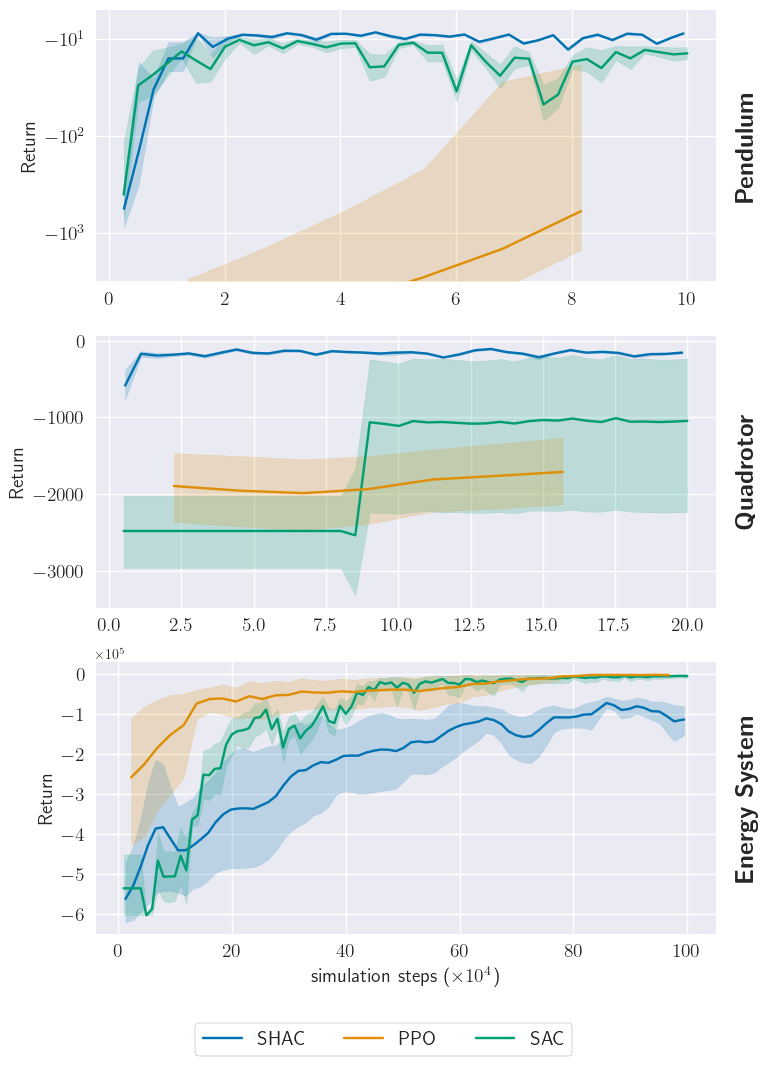

In [105]:
# Figure 6
plt.style.use("seaborn-v0_8")

colors = {
    "SHAC": sns.color_palette("colorblind")[0],
    "PPO": sns.color_palette("colorblind")[1],
    "SAC": sns.color_palette("colorblind")[2],
}

row = {
    "Pendulum": 0,
    "Quadrotor": 1,
    "Energy System": 2,
}

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False, sharey=False)

for ax, title in zip(axes, ["Pendulum", "Quadrotor", "Energy System"]):
    ax.text(1.05, 0.5, fr"\textbf{{{title}}}", va='center', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=18, fontweight='bold')
for ax in axes[:]:
    ax.set_ylabel("Return", fontsize=14)
for ax in axes[-1:]:
    ax.set_xlabel(r"simulation steps ($\times 10^4$)", fontsize=14)

axes[0].set_yscale("symlog")
axes[0].set_yticks([-1e3, -1e2, -1e1])
axes[0].set_ylim([-3162, -5e0])
axes[2].set_yticks([-6e5, -5e5, -4e5, -3e5, -2e5, -1e5, 0])
axes[2].set_ylim([-650000, 30000])
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

for env in env_translation.keys():
    for algo in algorithms:
        x = results[env][algo]["No Safeguard"]["steps"] / 1e4
        y, y_lower, y_upper = bootstrap_mean_ci(results[env][algo]["No Safeguard"]["reward"])
        if len(x) != len(y):
            x = x[:-1]

        color = colors[algo]

        axes[row[env]].plot(x, y, color=color, label=algo)
        axes[row[env]].fill_between(x, y_lower, y_upper, color=color, alpha=0.2)

shac_handle = mlines.Line2D([], [], color=colors["SHAC"])
ppo_handle = mlines.Line2D([], [], color=colors["PPO"])
sac_handle = mlines.Line2D([], [], color=colors["SAC"])

handles = [
    shac_handle, ppo_handle, sac_handle,
]
labels = [
    "SHAC", "PPO", "SAC",
]

fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    fontsize=14,
    ncol=3,
    fancybox=True,
    frameon=True,
    edgecolor="grey",
    facecolor="white"
)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("unsafe_results.pdf", backend="pgf", bbox_inches="tight")
plt.show()

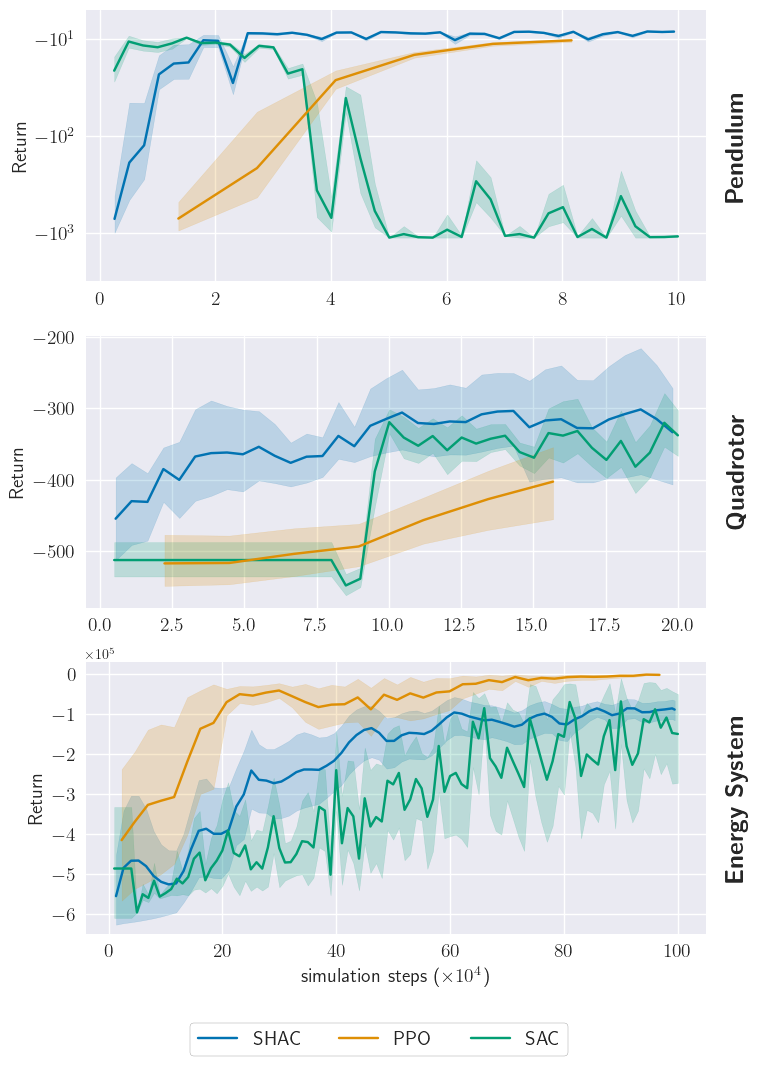

In [106]:
# Figure 7
plt.style.use("seaborn-v0_8")

colors = {
    "SHAC": sns.color_palette("colorblind")[0],
    "PPO": sns.color_palette("colorblind")[1],
    "SAC": sns.color_palette("colorblind")[2],
}

row = {
    "Pendulum": 0,
    "Quadrotor": 1,
    "Energy System": 2,
}

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False, sharey=False)

for ax, title in zip(axes, ["Pendulum", "Quadrotor", "Energy System"]):
    ax.text(1.05, 0.5, rf"\textbf{{{title}}}", va='center', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=18, fontweight='bold')
for ax in axes[:]:
    ax.set_ylabel("Return", fontsize=14)
for ax in axes[-1:]:
    ax.set_xlabel(r"simulation steps ($\times 10^4$)", fontsize=14)
axes[0].set_yscale("symlog")
axes[0].set_yticks([-1e3, -1e2, -1e1])
axes[0].set_ylim([-3162, -5e0])
axes[2].set_yticks([-6e5, -5e5, -4e5, -3e5, -2e5, -1e5, 0])
axes[2].set_ylim([-650000, 30000])
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

for env in env_translation.keys():
    for algo in algorithms:
        x = results[env][algo]["Boundary Projection Base"]["steps"] / 1e4
        y, y_lower, y_upper = bootstrap_mean_ci(results[env][algo]["Boundary Projection Base"]["reward"])
        if len(x) != len(y):
            x = x[:-1]

        color = colors[algo]

        axes[row[env]].plot(x, y, color=color, label=algo)
        axes[row[env]].fill_between(x, y_lower, y_upper, color=color, alpha=0.2)

shac_handle = mlines.Line2D([], [], color=colors["SHAC"])
ppo_handle = mlines.Line2D([], [], color=colors["PPO"])
sac_handle = mlines.Line2D([], [], color=colors["SAC"])

handles = [
    shac_handle, ppo_handle, sac_handle,
]
labels = [
    "SHAC", "PPO", "SAC",
]

fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    fontsize=14,
    ncol=3,
    fancybox=True,
    frameon=True,
    edgecolor="grey",
    facecolor="white"
)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("bp_results.pdf", backend="pgf", bbox_inches="tight")

plt.show()

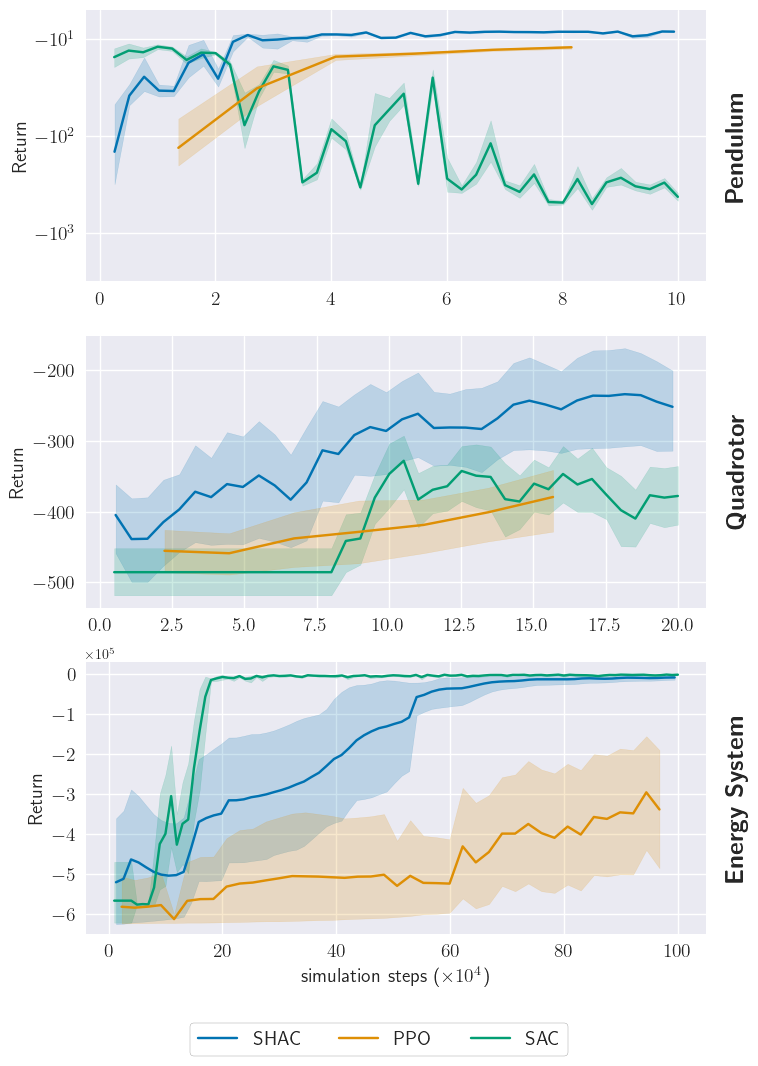

In [107]:
# Figure 8
plt.style.use("seaborn-v0_8")

colors = {
    "SHAC": sns.color_palette("colorblind")[0],
    "PPO": sns.color_palette("colorblind")[1],
    "SAC": sns.color_palette("colorblind")[2],
}

row = {
    "Pendulum": 0,
    "Quadrotor": 1,
    "Energy System": 2,
}

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False, sharey=False)

for ax, title in zip(axes, ["Pendulum", "Quadrotor", "Energy System"]):
    ax.text(1.05, 0.5, rf"\textbf{{{title}}}", va='center', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=18, fontweight='bold')
for ax in axes[:]:
    ax.set_ylabel("Return", fontsize=14)
for ax in axes[-1:]:
    ax.set_xlabel(r"simulation steps ($\times 10^4$)", fontsize=14)
axes[0].set_yscale("symlog")
axes[0].set_yticks([-1e3, -1e2, -1e1])
axes[0].set_ylim([-3162, -5e0])
axes[2].set_yticks([-6e5, -5e5, -4e5, -3e5, -2e5, -1e5, 0])
axes[2].set_ylim([-650000, 30000])
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
for env in env_translation.keys():
    for algo in algorithms:
        x = results[env][algo]["Ray Mask Base"]["steps"] / 1e4
        y, y_lower, y_upper = bootstrap_mean_ci(results[env][algo]["Ray Mask Base"]["reward"])
        if len(x) != len(y):
            x = x[:-1]

        color = colors[algo]

        axes[row[env]].plot(x, y, color=color, label=algo)
        axes[row[env]].fill_between(x, y_lower, y_upper, color=color, alpha=0.2)

shac_handle = mlines.Line2D([], [], color=colors["SHAC"])
ppo_handle = mlines.Line2D([], [], color=colors["PPO"])
sac_handle = mlines.Line2D([], [], color=colors["SAC"])

handles = [
    shac_handle, ppo_handle, sac_handle,
]
labels = [
    "SHAC", "PPO", "SAC",
]

fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    fontsize=14,
    ncol=3,
    fancybox=True,
    frameon=True,
    edgecolor="grey",
    facecolor="white"
)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("rm_results.pdf", backend="pgf", bbox_inches="tight")

plt.show()

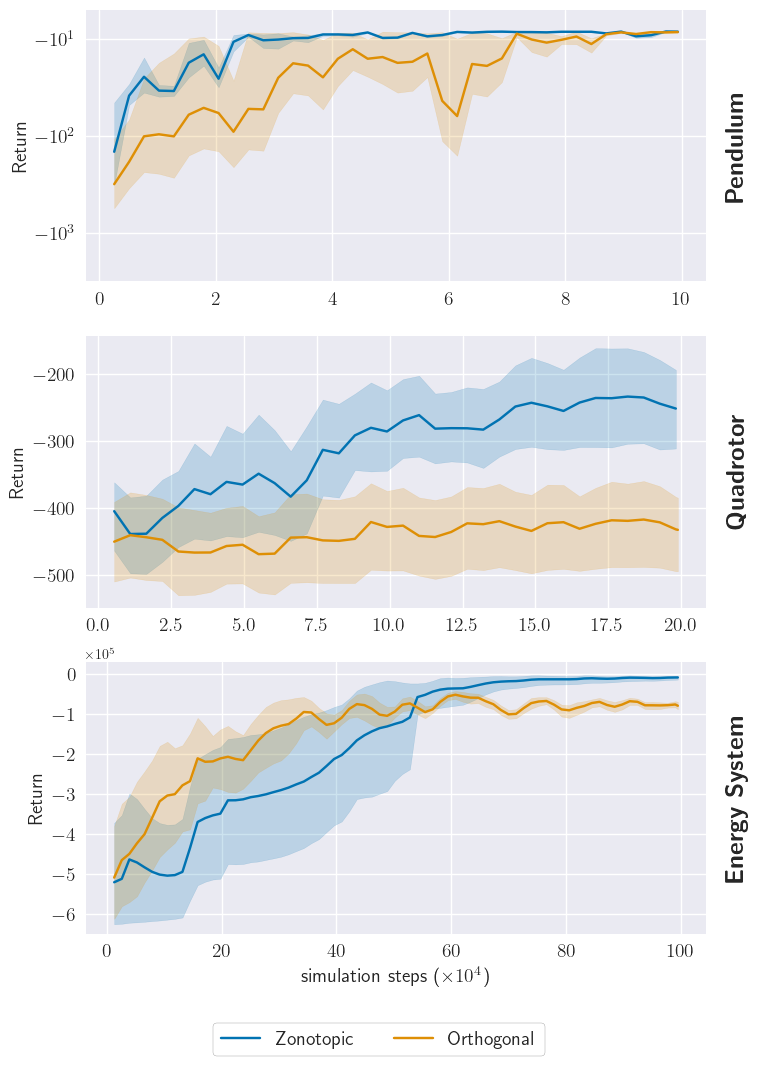

In [108]:
# Figure 9
plt.style.use("seaborn-v0_8")

colors = {
    "Ray Mask Base": sns.color_palette("colorblind")[0],
    "Ray Mask Orthogonal": sns.color_palette("colorblind")[1],
}

row = {
    "Pendulum": 0,
    "Quadrotor": 1,
    "Energy System": 2,
}

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False, sharey=False)

for ax, title in zip(axes, ["Pendulum", "Quadrotor", "Energy System"]):
    ax.text(1.05, 0.5, rf"\textbf{{{title}}}", va='center', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=18, fontweight='bold')
for ax in axes[:]:
    ax.set_ylabel("Return", fontsize=14)
for ax in axes[-1:]:
    ax.set_xlabel(r"simulation steps ($\times 10^4$)", fontsize=14)
axes[0].set_yscale("symlog")
axes[0].set_yticks([-1e3, -1e2, -1e1])
axes[0].set_ylim([-3162, -5e0])
axes[2].set_yticks([-6e5, -5e5, -4e5, -3e5, -2e5, -1e5, 0])
axes[2].set_ylim([-650000, 30000])
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

for env in env_translation.keys():
    for approx in ["Ray Mask Base", "Ray Mask Orthogonal"]:
        x = results[env]["SHAC"][approx]["steps"] / 1e4
        y, y_lower, y_upper = bootstrap_mean_ci(results[env]["SHAC"][approx]["reward"])
        if len(x) != len(y):
            x = x[:-1]

        color = colors[approx]

        axes[row[env]].plot(x, y, color=color, label=approx)
        axes[row[env]].fill_between(x, y_lower, y_upper, color=color, alpha=0.2)

z_handle = mlines.Line2D([], [], color=colors["Ray Mask Base"])
o_handle = mlines.Line2D([], [], color=colors["Ray Mask Orthogonal"])

handles = [
    z_handle, o_handle
]
labels = [
    "Zonotopic", "Orthogonal"
]

fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    fontsize=14,
    ncol=2,
    fancybox=True,
    frameon=True,
    edgecolor="grey",
    facecolor="white"
)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("centre_approximations_results.pdf", backend="pgf", bbox_inches="tight")

plt.show()

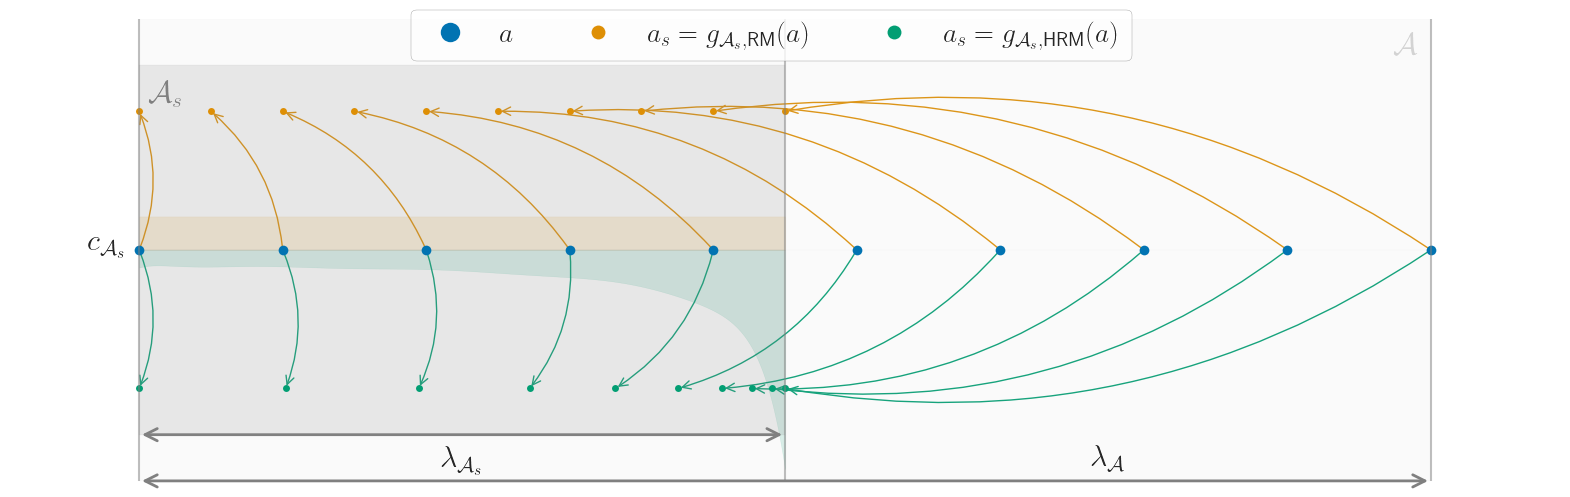

In [109]:
def linear_map(x, a, s):
    return x / a


def hyperbolic_map(x, a, s):
    return np.tanh(x / s) / np.tanh(a / s)


a = 1
x = np.linspace(0, 1, 10)
s = 0.5

y_lin = linear_map(x, a, s) * s
y_tanh = hyperbolic_map(x, a, s) * s

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.5, 0.5)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
ax.set_xticks(np.linspace(0, 1, 11))

ax.plot(x, np.zeros_like(x), 'o', label='$a$', color=sns.color_palette("colorblind")[0])
ax.plot(y_lin, np.full_like(y_lin, 0.3), 'o', label=r'$a_s = g_{\mathcal{A}_s, \text{RM}}(a)$', ms=5,
        color=sns.color_palette("colorblind")[1])
ax.plot(y_tanh, np.full_like(y_tanh, -0.3), 'o', label=r'$a_s = g_{\mathcal{A}_s, \text{HRM}}(a)$', ms=5,
        color=sns.color_palette("colorblind")[2])

for xi, yl, yh in zip(x, y_lin, y_tanh):
    arrow1 = FancyArrowPatch(
        (xi, 0), (yl, 0.3),
        connectionstyle="arc3,rad=0.2",
        arrowstyle='->',
        color=sns.color_palette("colorblind")[1],
        mutation_scale=15, lw=1
    )
    ax.add_patch(arrow1)
    arrow2 = FancyArrowPatch(
        (xi, 0), (yh, -0.3),
        connectionstyle="arc3,rad=-0.2",
        arrowstyle='->',
        color=sns.color_palette("colorblind")[2],
        mutation_scale=15, lw=1
    )
    ax.add_patch(arrow2)

ax.vlines(0.0, -0.5, 0.5, color='grey', linewidth=1.5, alpha=0.5)
ax.annotate(r'$c_{\mathcal{A}_s}$', xy=(-0.025, 0.0), ha='center', fontsize=22)

ax.vlines(0.5, -0.5, 0.5, color='grey', linewidth=1.5, alpha=0.5)
ax.annotate(
    r'', xy=(0.5, -0.4), xytext=(0.0, -0.4),
    arrowprops=dict(arrowstyle='<->', color='grey', lw=2), fontsize=22
)
ax.annotate(r'$\lambda_{\mathcal{A}_s}$', xy=(0.25, -0.47), ha='center', fontsize=22)

ax.vlines(1.0, -0.5, 0.5, color='grey', linewidth=1.5, alpha=0.5)
ax.annotate(
    r'', xy=(1.0, -0.5), xytext=(0.0, -0.5),
    arrowprops=dict(arrowstyle='<->', color='grey', lw=2), fontsize=22
)
ax.annotate(r'$\lambda_\mathcal{A}$', xy=(0.75, -0.47), ha='center', fontsize=22)

ax.set_facecolor('white')

ax.legend(loc='upper left', ncols=3, fontsize=20, fancybox=True,
          frameon=True,
          edgecolor="grey",
          facecolor="white",
          markerscale=2.0,
          bbox_to_anchor=(0.25, 1.05))

n = 10000

x_dense = np.linspace(0, 1, n * 10)
y_lin_dense = linear_map(x_dense, a, s) * s
y_tanh_dense = hyperbolic_map(x_dense, a, s) * s

lin_hist = histogram(y_lin_dense, 0, 0.5, bins=n)
tanh_hist = histogram(y_tanh_dense, 0, 0.5, bins=n)
scaler = np.max([np.max(lin_hist), np.max(tanh_hist)])
x_hist = np.linspace(0, 0.5, n)

coeffs = np.polyfit(x_hist, -tanh_hist / scaler * 0.5, 10)
p = np.poly1d(coeffs)
y_value = p(x_hist)

ax.fill_between(
    x_hist, lin_hist / scaler * 0.5, color=sns.color_palette("colorblind")[1], alpha=0.15
)
ax.fill_between(
    x_hist, y_value, color=sns.color_palette("colorblind")[2], alpha=0.15
)

ax.fill_between([0.0, 1.0], [0.5, 0.5], color="lightgrey", alpha=0.1)
ax.fill_between([0.0, 1.0], [-0.5, -0.5], color="lightgrey", alpha=0.1)
ax.annotate(r'$\mathcal{A}$', xy=(0.98, 0.42), ha='center', fontsize=22, color="lightgrey")

ax.fill_between([0.0, 0.5], [0.4, 0.4], color="grey", alpha=0.15)
ax.fill_between([0.0, 0.5], [-0.4, -0.4], color="grey", alpha=0.15)
ax.annotate(r'$\mathcal{A}_s$', xy=(0.02, 0.32), ha='center', fontsize=22, color="grey")

ax.axhline(y=1, color='r', linestyle='--', label='Theoretical PDF (p(y)=1)')

plt.savefig("mapping.pdf", backend="pgf", bbox_inches="tight")

plt.show()

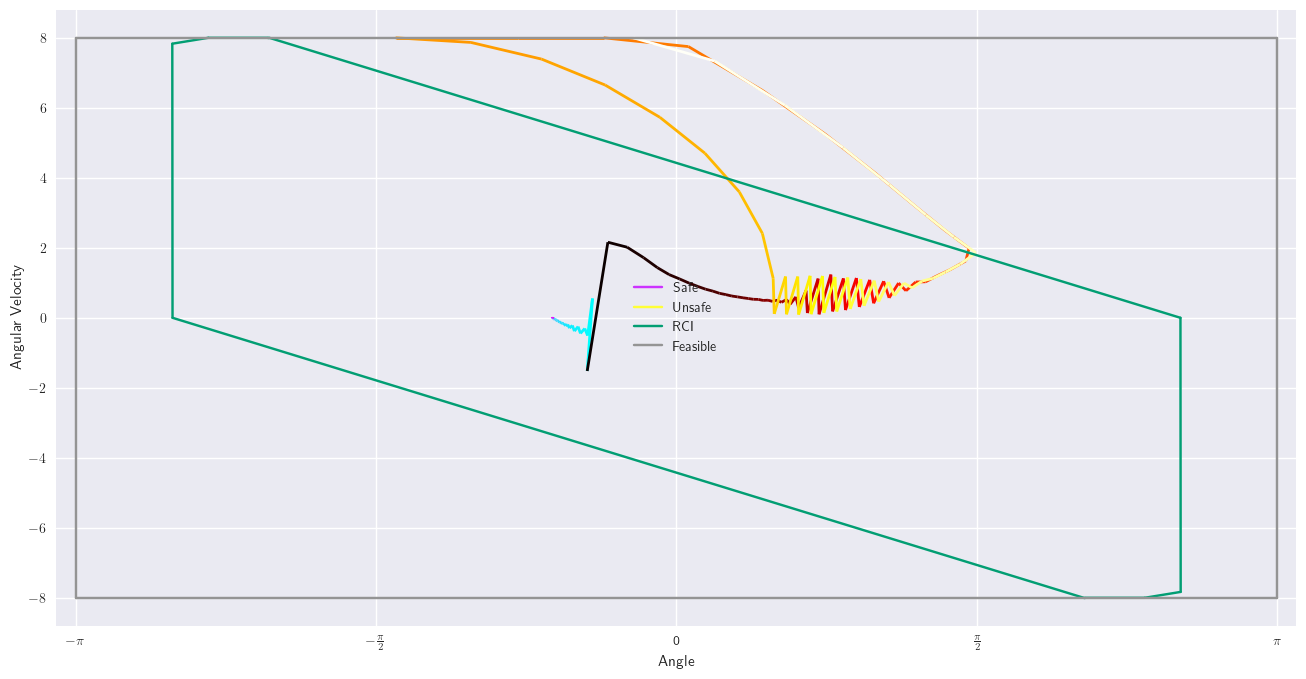

In [117]:
from envs.balance_pendulum import BalancePendulumEnv
from learning_algorithms.components.policy import Policy
from safeguards.ray_mask import RayMaskSafeguard
from safeguards.boundary_projection import BoundaryProjectionSafeguard

from scipy.spatial import ConvexHull
import torch

rci = BalancePendulumEnv(1, 100).rci
vertices = rci.vertices().cpu()
vertices[1, :] = vertices[1, :] / vertices[1, :].max() * 8
vertices2 = BalancePendulumEnv(1, 100).state_set.vertices().cpu()

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
unsafe_policy = torch.load("../unsafe_policy.pt", weights_only=False)
env = BalancePendulumEnv(1, 100)
#env.TORQUE_MAG = 30
torch.manual_seed(1)
obs, info = env.reset()
unsafe_states = [torch.tensor([torch.arcsin(obs[0, 0]), obs[0, 2]])]
unsafe_actions = []
for i in range(100):
    action = unsafe_policy.predict(obs)
    unsafe_actions += [action]
    obs, _, _, _, _ = env.step(action)
    unsafe_states += [torch.tensor([torch.arcsin(obs[0, 0]), obs[0, 2]])]

unsafe_states = torch.stack(unsafe_states, dim=0).cpu()

safe_policy = torch.load("../safe_policy.pt", weights_only=False)
env = RayMaskSafeguard(env, linear_projection=True, passthrough=True, zonotopic_approximation=True)
torch.manual_seed(1)
obs, info = env.reset()
states = [torch.tensor([torch.arcsin(obs[0, 0]), obs[0, 2]])]
safe_actions = []
for i in range(100):
    action = safe_policy.predict(obs)
    safe_actions += [action]
    obs, _, _, _, _ = env.step(action)
    states += [torch.tensor([torch.arcsin(obs[0, 0]), obs[0, 2]])]

states = torch.stack(states, dim=0).cpu()

import matplotlib.collections as mcoll


def colorline(x, y, cmap='viridis', norm=None, ax=None, label=None):
    """Draw a colored line with coordinates x and y."""
    ax = ax or plt.gca()

    # Create line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Normalize values along the line
    if norm is None:
        norm = plt.Normalize(0, 1)
    lc = mcoll.LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.linspace(0, 1, len(x)))
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

    # For legend: add a proxy artist
    ax.plot([], [], color=line.cmap(0.8), label=label)

    return line


colors = sns.color_palette("colorblind")

plt.figure(figsize=(16, 8))
ax = plt.gca()
colorline(states[:, 0], states[:, 1], cmap='cool', ax=ax, label="Safe")
colorline(unsafe_states[:, 0], unsafe_states[:, 1], cmap='hot', ax=ax, label="Unsafe")

#ax.plot(states[:, 0], states[:, 1], label="Safe", color=colors[0])
#ax.plot(unsafe_states[:, 0], unsafe_states[:, 1], label="Unsafe", color=colors[1])

for i, simplex in enumerate(ConvexHull(vertices.T).simplices):
    ax.plot(vertices[0, simplex], vertices[1, simplex], label="RCI" if i == 0 else None, color=colors[2])
for i, simplex in enumerate(ConvexHull(vertices2.T).simplices):
    ax.plot(vertices2[0, simplex], vertices2[1, simplex], label="Feasible" if i == 0 else None, color=colors[7])

ax.set_xlabel('Angle')
ax.set_xlim([-torch.pi - 0.1, torch.pi + 0.1])
ax.set_xticks([-torch.pi, -torch.pi / 2, 0, torch.pi / 2, torch.pi])
ax.xaxis.set_major_locator(mticker.MultipleLocator(np.pi / 2))


def pi_formatter(x, pos):
    """Formats the tick value as a LaTeX fraction of pi."""
    if np.isclose(x, 0):
        return "0"

    num = np.pi // x

    sign = "-" if num < 0 else ""

    if np.abs(num) == 1:
        return fr'${sign}\pi$'
    else:
        return fr'${sign}\frac{{\pi}}{{{int(np.abs(num))}}}$'


ax.xaxis.set_major_formatter(mticker.FuncFormatter(pi_formatter))

ax.set_ylabel('Angular Velocity')
ax.legend()
ax.grid(True)
plt.show()